# Reinforcement learning
Auteurs: 
Sami El Kateb
Theo Jeannes

In [1]:
import numpy as np
import keras_tuner
import keras
import pandas as pd
from dataclasses import dataclass

from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

pd.options.display.max_columns = 200
keras.utils.set_random_seed(42)

Using TensorFlow backend


In [2]:
@dataclass
class ProcessedData:
  def __init__(self, X, y):
    self.X = X.copy()
    self.y = y.copy(deep=True)

  def copy(self):
    return ProcessedData(self.X.copy(), self.y.copy())

In [3]:
y = pd.read_csv("./data/y.csv", header=None)
X = pd.read_csv("./data/X.csv", header=None)
print(y.shape)
print(X.shape)

(14154, 1)
(14154, 2040)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# The dataset is not balanced

In [5]:
y_train.groupby(0)[0].count()

0
0    8597
1     835
2    1183
Name: 0, dtype: int64

In [6]:
# Ces deux methodes permettent de rééquilibrer les classes pour eviter la surepresentation de la classe 0.
# random_under_sampler = RandomUnderSampler(random_state=42)
# X_train, y_train = random_under_sampler.fit_resample(X_train, y_train)

smoteenn = SMOTEENN(random_state=42)
X_train, y_train = smoteenn.fit_resample(X_train, y_train)

In [7]:
X_train = X_train.to_numpy().reshape(-1, 40, 51, 1)
X_test = X_test.to_numpy().reshape(-1, 40, 51, 1)

In [8]:
y_train.groupby(0)[0].count()

0
0    1107
1    3639
2    3593
Name: 0, dtype: int64

In [9]:
train = ProcessedData(X_train, y_train)
test = ProcessedData(X_test, y_test)

In [10]:
# Extension de la classe BayesianOptimization pour permettre l'accès aux historiques des modèles entrainés.
class BayesianOptimization(keras_tuner.BayesianOptimization):
    histories = {}

    # À la fin de chaque époque, on ajoute les métriques à l'historique de l'essai en cours
    def on_epoch_end(self, trial, model, epoch, logs=None):
        trial_id = trial.trial_id
        trial_history = self.histories.setdefault(trial_id, {})
        for metric, value in logs.items():
            trial_history.setdefault(metric, []).append(value)

In [11]:
def build_model(hp):
    
    input = Input(shape=(40, 51, 1))
    # Optimisation du réseau de neurones
    x = Conv2D(hp.Int(f'conv_filter_0', 3, 9, step=3), hp.Int(f'kernel_size_0', 3, 5, step=2), activation='relu')(input)
    for i in range(hp.Int('layers', 0, 4)):
        x = Conv2D(hp.Int(f'conv_filter_{str(i+1)}', 3, 9, step=3), hp.Int(f'kernel_size_{str(i+1)}', 3, 9, step=2), activation='relu')(x)
        if hp.Boolean("WithMaxPool", default=False):
            x = MaxPooling2D(hp.Int(f'max_pool_size_{str(i+1)}', 2, 6, step=2), strides=hp.Int(f'max_pool_strides_{str(i+1)}', 1, 4, step=10), padding='same')(x)
    x = Flatten()(x)

    output = Dense(3, activation='softmax')(x)
    model = Model(input, output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    overwrite=True,
    max_trials=4)

early_stopping_cb = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=1, mode='max', baseline=None, restore_best_weights=True)
tuner.search(train.X, train.y, validation_split=0.2, epochs=1000, callbacks=[early_stopping_cb])

Trial 4 Complete [00h 01m 02s]
val_accuracy: 0.9904077053070068

Best val_accuracy So Far: 0.9982014894485474
Total elapsed time: 00h 05m 57s


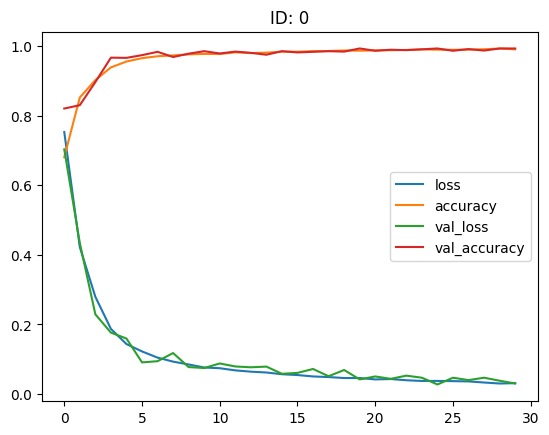

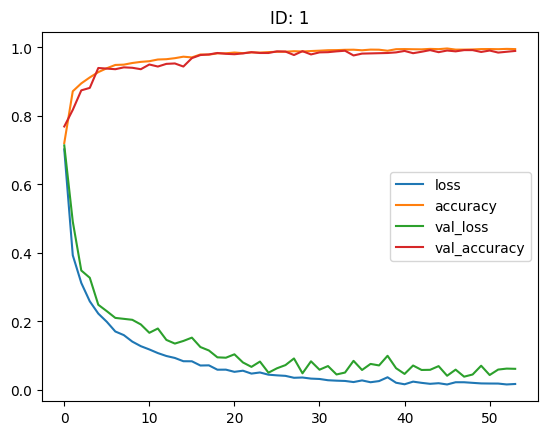

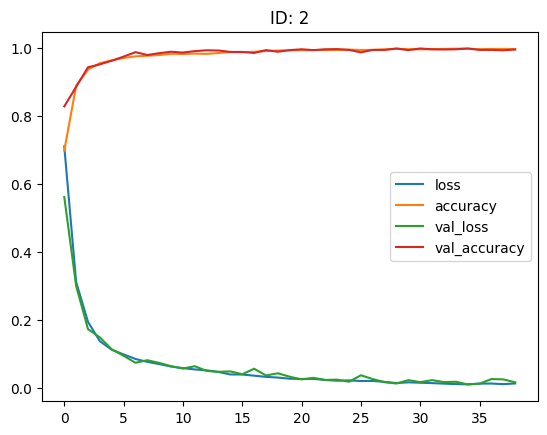

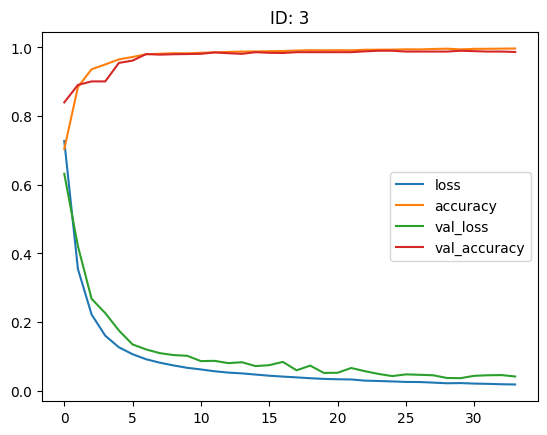

In [12]:
accuracies = [0]*len(tuner.oracle.trials)
losses = [0]*len(tuner.oracle.trials)
model = tuner.get_best_models()[0]
for id_trial, history in tuner.histories.items():
    pd.DataFrame(history).plot(title=f"ID: {id_trial}")
    accuracies[int(id_trial)] = history['val_accuracy']
    losses[int(id_trial)] = history['val_loss']    

,conv_filter_0,kernel_size_0,layers,conv_filter_1,kernel_size_1,WithMaxPool
Modèle 0,9,5,1,3,3,False
Modèle 1,6,3,3,6,5,True
Modèle 2,6,5,1,6,3,False
Modèle 3,9,3,0,3,5,False


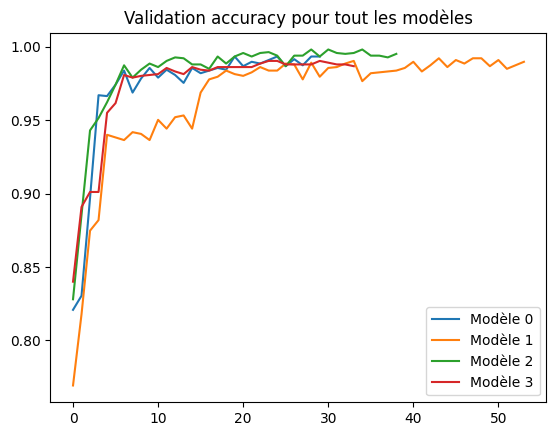

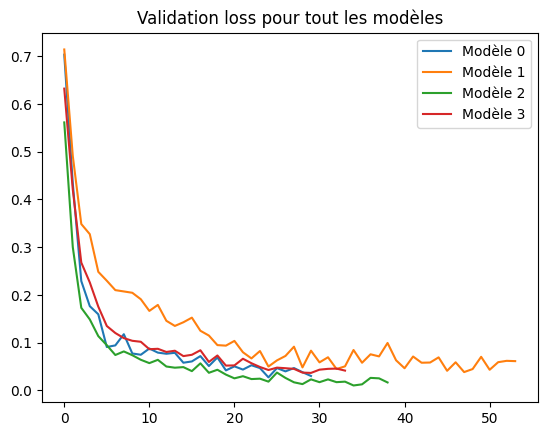

In [13]:
indexes = []
# On compare la precision et la loss sur la validation de chaque modèle.
# Cela permet de visualiser les changements de precisions et de loss en fonction des topologies des modelès
hyperparameters = pd.DataFrame()
length = len(str(len(tuner.oracle.trials)))
for i in range(len(tuner.oracle.trials)):
    number = '0'* (length-(i//10+1)) + str(i)
    indexes.append('Modèle '+str(i))
    hyperparameters['Modèle '+str(i)] = tuner.oracle.get_trial(number).hyperparameters.values
pd.DataFrame(accuracies, index=indexes).T.plot(title="Validation accuracy pour tout les modèles", legend=True)
pd.DataFrame(losses, index=indexes).T.plot(title="Validation loss pour tout les modèles", legend=True)
hyperparameters.T

In [14]:
best_model = tuner.get_best_models()[0] # On récupère le meilleur modèle apres le fine-tuning
best_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 51, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 36, 47, 6)         156       
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 45, 6)         330       
                                                                 
 flatten (Flatten)           (None, 9180)              0         
                                                                 
 dense (Dense)               (None, 3)                 27543     
                                                                 
Total params: 28029 (109.49 KB)
Trainable params: 28029 (109.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


 74/111 [===================>..........] - ETA: 0s

2023-10-06 01:17:47.501068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.91      0.38      0.54      2884
           1       0.15      0.60      0.23       255
           2       0.20      0.64      0.30       400

    accuracy                           0.43      3539
   macro avg       0.42      0.54      0.36      3539
weighted avg       0.78      0.43      0.49      3539



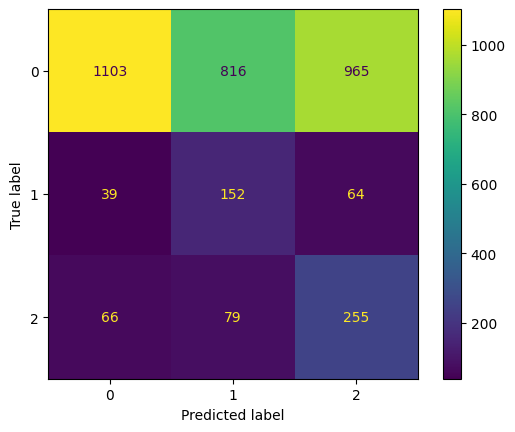

In [15]:
y_pred = best_model.predict(test.X)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(test.y, y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test.y, y_pred)).plot()

In [16]:
best_model.save(f"./models/pong.h5") # On sauvegarde le meilleur modèle, pour jouer avec eux après

/Users/Sami/polytech/jupyter-env/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Random Forest

In [17]:
classifier = RandomForestClassifier(n_estimators=500, criterion="entropy")
X_train_random_forest = X_train.reshape(-1, 40 * 51)
X_test_random_forest = X_test.reshape(-1, 40 * 51)
classifier.fit(X_train_random_forest, y_train[0])
dump(classifier, 'models/pong-random-forest.joblib')

['models/pong-random-forest-v2.joblib']

              precision    recall  f1-score   support

           0       0.94      0.19      0.32      2884
           1       0.12      0.60      0.19       255
           2       0.17      0.67      0.27       400

    accuracy                           0.28      3539
   macro avg       0.41      0.49      0.26      3539
weighted avg       0.79      0.28      0.31      3539



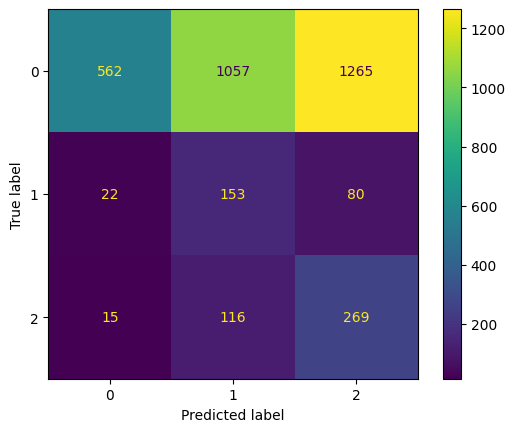

In [18]:
classifier.score(X_test_random_forest, y_test)
y_pred = classifier.predict(X_test_random_forest)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()